# NRM python upstream client library tutorial

This tutorial covers the use of NRM's python upstream client library, in the context of running an external resource management strategy. Its cell's output are deterministic, and the executed version that is vendored in the source tree is checked by the project's CI, so its behavior should always be up-to-date with the latest version of the software, and no cells should be throwing exceptions.  



## Setup

This notebook uses `nrm`'s python library bindings and needs the `nrmd` daemon in the `$PATH`. 

Assuming the project is cloned **with submodules updated** (and the code unmodified), one needs to run the following from the root of the project before running it:

In [1]:
%%capture
cd ..

The next cell builds the shared libraries. This should take about a minute on a modern laptop.

In [2]:
%%capture
%%bash
./shake.sh build # for the daemon 
./shake.sh client # for the upstream client
./shake.sh pyclient # for the shared client library

This allows to use the command-line daemon and client in the working directory, should you need to for debugging purposes. Those should be available in jupyter-lab terminal tabs once the previous cell finishes. You should however only need them for debugging purposes: this notebook shows how to use the python nrm interface. 

In [3]:
%%bash
nrmd --help

nrmd

Usage: <unknown> [-i|--stdin] [CONFIG] [-y|--yaml]
  NRM Daemon

Available options:
  -h,--help                Show this help text
  -i,--stdin               Read configuration on stdin.
  CONFIG                   Input configuration with .yml/.yaml/.dh/.dhall
                           extension. Leave void for stdin (dhall) input.
  -y,--yaml                Assume configuration to be yaml(json is valid yaml)
                           instead of dhall.
  -h,--help                Show this help text


In [4]:
%%bash 
nrm --help
echo ""
nrm run --help

nrm

Usage: nrm COMMAND
  NRM Client

Available options:
  -h,--help                Show this help text
  COMMAND                  Choice of operation.

Available commands:
  run                      Run the application via NRM
  killcmd                  Kill cmd
  killslice                Kill slice
  actuate                  Send actuator action
  cpd                      Show current CPD
  list                     List existing slices
  state                    Show NRM state
  config                   Show NRM configuration
  listen-raw               Listen to raw NRM upstream pub messages
  listen-cpd               Listen to CPD messages
  listen-all               Listen to all upstream pub messages

Usage: nrm run [-i|--stdin] [-y|--yaml] [-d|--detach] [--manifest MANIFEST]
               [-s|--slice CONTAINER] CMD [ARG] [-v|--verbose] [-j|--json]
               [-c|--color] [--pub_port PORT] [--rpc_port PORT]
               [--bind_address ADDRESS]
  Run the application via NRM


## Defining experiments

Now that the daemon is properly set-up, we will configure and run some experiments using the python interface.



In [5]:
%load_ext nb_black
import nrm.tooling as nrm
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

This notebook will start `nrmd` on the same machine as the notebok, but the same interface should be available for remote execution:

In [6]:
host = nrm.Local()
# host=Remote( target="cc@129.114.108.201")

<IPython.core.display.Javascript object>

Note that the two classes (`Local` and `Remote`) offer the same methods to start nrmd and interact via blocking message passing primitives. The supported methods are the following:

In [7]:
import inspect

for a, x in inspect.getmembers(host, predicate=inspect.ismethod):
    print("%s: %s" % (a, x.__doc__))

__init__: None
check_daemon:  checks if nrmd is alive 
get_cpd:  Obtain the current Control Problem Description 
get_state:  Obtain the current daemon state 
run_workload:  Runs a workload via NRM. The `nrmd` daemon must be running. 
start_daemon:  start nrmd 
stop_daemon:  stops nrmd 
workload_action:  Send a message to NRM's upstream API. 
workload_exit_status:  Check the workload's exit status. 
workload_finished:  Checks NRM to see whether all tasks are finished. 
workload_recv:  Receive a message from NRM's upstream API. 


<IPython.core.display.Javascript object>

The next cell defines some node experimental node (`nrmd`) daemon configurations and some workloads. Please see notebook [notebooks/configuration.ipynb](notebooks/configuration.ipynb) for an overview of `nrmd`'s and the "Manifest"'s configuration format.

In [8]:
daemonCfgs = {
    "redirected_log": {"logfile": "/tmp/logfile_experiment2", "verbose": "Info"},
    # "other":your code
}

workloads = {
    "dummy": [
        {
            "cmd": "sleep",
            "args": ["10"],  # running the sleep command for 10 seconds.
            "sliceID": "toto",
            "manifest": {
                "app": {
                    "slice": {"cpus": 1, "mems": 1},
                    "perfwrapper": {
                        "perfLimit": {"fromOps": 100000},
                        "perfFreq": {"fromHz": 1},
                    },
                },
                "name": "perfwrap",
            },
        }
    ],
    # "other":your code
}

<IPython.core.display.Javascript object>

The next cell defines some experiments:

In [9]:
experiments = {
    "example": (daemonCfgs["redirected_log"], workloads["dummy"]),
    # "other": your code
}

<IPython.core.display.Javascript object>

## Running experiments
The next cell shows how to start the daemon. This acts as a silent restart in case the daemon was still running beforehand.

In [10]:
host.start_daemon(daemonCfgs["redirected_log"])
assert host.check_daemon()

connecting
connected to tcp://localhost:2345


<IPython.core.display.Javascript object>

We can obtain the current control description problem:

In [11]:
cpd = host.get_cpd()
print("Pretty-printing the control problem description:\n %s" % cpd)
cpdd = dict(cpd)
print("Python dictionary version: %s" % cpdd)

Pretty-printing the control problem description:
 Problem 
    { sensors = Map 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 300.0
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = Map 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 100.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = []
    , constraints = []
    } 
Python dictionary version: {'objectives': [], 'constraints': [], 'sensors': [['RaplKey (PackageID 0)', {'maxFrequency': 3, 'range': {'i': [0, 300]}}]], 'actuators': [['RaplKey (PackageID 0)', {'actions': [100, 200]}]]}


<IPython.core.display.Javascript object>

As you can see, there is one sensor and one actuator, both corresponding to the same RAPL package. Not very interesting until we start a workload. We can take an action like so:

In [13]:
actuator0 = cpdd["actuators"][0]
actuator0ID = actuator0[0]
actuator0FirstAction = actuator0[1]["actions"][0]
print(
    "We take the first available action (%s) for the first actuator (%s)."
    % (actuator0FirstAction, actuator0ID)
)
host.workload_action([nrm.Action("RaplKey (PackageID 0)", 200)])

We take the first available action (100) for the first actuator (RaplKey (PackageID 0)).


<IPython.core.display.Javascript object>

Internal daemon state inspection, should you need it, is achieved in the following way:

In [14]:
s = host.get_state()
print(s)
print(dict(s))

NRMState 
    { pus = Map 
        [ 
            ( PUID 0
            , PU
            ) 
        , 
            ( PUID 4
            , PU
            ) 
        , 
            ( PUID 1
            , PU
            ) 
        , 
            ( PUID 5
            , PU
            ) 
        , 
            ( PUID 2
            , PU
            ) 
        , 
            ( PUID 6
            , PU
            ) 
        , 
            ( PUID 3
            , PU
            ) 
        , 
            ( PUID 7
            , PU
            ) 
        ] 
    , cores = Map 
        [ 
            ( CoreID 0
            , Core
            ) 
        , 
            ( CoreID 1
            , Core
            ) 
        , 
            ( CoreID 2
            , Core
            ) 
        , 
            ( CoreID 3
            , Core
            ) 
        ] 
    , packages = Map 
        [ 
            ( PackageID 0
            , Package 
                { rapl = Just 
                    ( Rapl 
       

<IPython.core.display.Javascript object>

The next cell just stops the daemon cleanly.

In [15]:
host.stop_daemon()
assert host.check_daemon() == False

<IPython.core.display.Javascript object>

### Dummy experiment: printing measurements

We now are ready to run an external resource management strategy. The next cell uses the low-level "upstream" message passing interface to run a dummy strategy that takes a constant action. Message schemas for this API can be browsed in the [./resources/](./resources/) folder.

In [17]:
from collections import defaultdict

for name, (daemonCfg, workload) in experiments.items():
    host.start_daemon(daemonCfg)
    print("Starting the workload")
    host.run_workload(workload)
    history = defaultdict(list)
    getCPD = True
    while host.check_daemon() and not host.workload_finished():
        measurement_message = host.workload_recv()
        msg = json.loads(measurement_message)
        # print("received raw message: %s" %msg)
        if "pubMeasurements" in msg:
            if getCPD:
                getCPD = False
                time.sleep(1)
                cpd = dict(host.get_cpd())
                print("Sensor identifier list:")
                for sensorID in [sensor[0] for sensor in cpd["sensors"]]:
                    print("- %s" % sensorID)
                print("Actuator identifier list:")
                for sensorID in [sensor[0] for sensor in cpd["actuators"]]:
                    print("- %s" % sensorID)
            content = msg["pubMeasurements"][1][0]
            t = content["time"]
            sensorID = content["sensorID"]
            x = content["sensorValue"]
            print("measured at time %s: sensor %s, value %s" % (t, sensorID, x))
            history[sensorID].append((t, x))
        host.workload_action([nrm.Action("RaplKey (PackageID 0)", 200)])
    host.check_daemon()

host.stop_daemon()

connecting
connected to tcp://localhost:2345
Starting the workload
Sensor identifier list:
- RaplKey (PackageID 0)
Actuator identifier list:
- RaplKey (PackageID 0)
measured at time 1582045560061246.8: sensor RaplKey (PackageID 0), value 0
measured at time 1582045561063255.5: sensor RaplKey (PackageID 0), value 15.294616938221127
measured at time 1582045562061654.2: sensor RaplKey (PackageID 0), value 15.775831049471757
measured at time 1582045562670140.2: sensor DownstreamCmdKey (DownstreamCmdID 8ea51690-6179-44bd-a70f-ce1e4c7b5971), value 0
measured at time 1582045563061716: sensor RaplKey (PackageID 0), value 15.138369205698176
measured at time 1582045563668666: sensor DownstreamCmdKey (DownstreamCmdID 8ea51690-6179-44bd-a70f-ce1e4c7b5971), value 0
measured at time 1582045564061267.5: sensor RaplKey (PackageID 0), value 13.551575881775197
measured at time 1582045564668714.2: sensor DownstreamCmdKey (DownstreamCmdID 8ea51690-6179-44bd-a70f-ce1e4c7b5971), value 0
measured at time 1582

<IPython.core.display.Javascript object>

Let's plot those sensor measurements. Not very interesting since our sleep job did not produce any operations, but here goes:

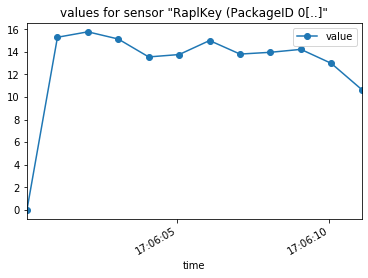

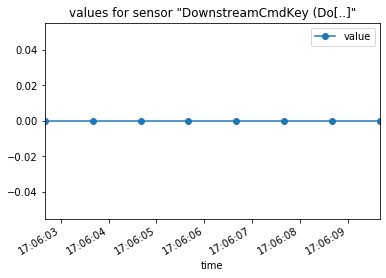

<IPython.core.display.Javascript object>

In [18]:
for sensorID, measurements in history.items():
    dataframe = pd.DataFrame(
        data=[(pd.Timestamp(t, unit="us"), m) for t, m in measurements]
    )
    dataframe.columns = ["time", "value"]
    dataframe = dataframe.set_index("time")
    ax = dataframe.plot(
        marker="o", linestyle="-", title='values for sensor "%s[..]"' % sensorID[:20]
    )

In [ ]:
x